# Feedback Control of a non-Markovian single qubit system
Shibei Xue, Thien Nguyen and Ian R. Peterson

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from qutip.cy.spmatfuncs import (cy_expect_rho_vec, spmv)
import numpy as np
import math
from qutip import *

### Implementation in QuTiP

The stochastic master equation on the form (Wiseman & Milburn):

$$ d\rho_c(t) = -i[H, \rho_c(t)] dt + \mathcal{D}[B] \rho_c(t) dt + \mathcal{D}[A]\rho_c(t) dt + \sqrt{\eta}\mathcal{H}[A]\rho_c(t) dW,$$

where $A$ are dissipation operators that are monitored.

This equation can be implemented by $D_1$ and $D_2$ callback functions in stochastic master equation.

# The model

Hamiltonian:
$$H_{total} = H_q + H_a + H_i,$$
where:
$$H_q = \frac{1}{2}\omega_0\sigma_z$$
$$H_a = \omega_a a^\dagger a$$
$$H_i = i(c^\dagger z - z^\dagger c)$$

$c = -\frac{\sqrt{\gamma}}{2}a$ and $z = \sqrt{\kappa}\sigma_-$


# Feedback

$$H_{fb}(t) = u_x(t) \sigma_x + u_z(t) \sigma_z, $$
where
$$u_x(t) = K_x (\bar{z} - \hat{z})$$
$$u_z(t) = K_z (\bar{x} - \hat{x})(\bar{y} - \hat{y})$$


In [57]:
# Parameters
gamma = 1.0
kappa = 1.0
omega_0 = 0.0
omega_a = 0.0
# Simulation time
tlist = np.linspace(0,2.5,2501)

# number of levels for ancillary systems
Nanc = 10 

# qubit Pauli operators
sm1 = tensor(sigmam(), qeye(Nanc))
sz1 = tensor(sigmaz(), qeye(Nanc))
sy1 = tensor(sigmay(), qeye(Nanc))
sx1 = tensor(sigmax(), qeye(Nanc))

# Ancillary cavity 1 operator
a1 = tensor(qeye(2), destroy(Nanc))

# Qubit Hamiltonian
Hq = 0.5*omega_0*sz1

# Ancilla Hamiltonian
Ha = omega_a*a1.dag()*a1

# Interaction Hamiltonian
c = -(np.sqrt(gamma)/2.0)*a1
z = np.sqrt(kappa)*sm1
Hi = 1j*(c.dag()*z - z.dag()*c)

# Total Hamiltonian
H = Hq + Ha + Hi

# Dissipation operator of the ancilla cavity    
L = np.sqrt(gamma)*a1

# Expectation Bloch operators
Ex = sx1
Ey = sy1
Ez = sz1

# No deterministic dissipation
c_ops = []

# Stochastic (monitored channel)
sc_ops = [L]

# intial state: random state
psi0 = tensor(rand_ket(2), basis(Nanc,0))    

# target state: 
psi_target = tensor(rand_ket(2), basis(Nanc,0))    
xBar = expect(sx1, psi_target)
yBar = expect(sy1, psi_target)
zBar = expect(sz1, psi_target)
#theta = math.pi/2.0
# Control parameters
Kx = -10.0
Kz = -10.0

# (A) superoperator definition 
#     A[0] = spre(a) = A_L : Multiply on the left
#     A[1] = spost(a) = A_R : Multiply on the right
#     A[2] = spre(a.dag()) = Ad_L : Adjoint and Multiply on the left
#     A[3] = spost(a.dag()) = Ad_R: Adjoint and Multiply on the right
#     A[4] = spre(a.dag() * a) = (Ad A)_L: Multiply on the left by L^\dagger L
#     A[5] = spost(a.dag() * a) = (Ad A)_R: Multiply on the right by L^\dagger L
#     A[6] = (spre(a) * spost(a.dag()) = A_L * Ad_R: Multiply on the left by L and multiply on the right by L^\dagger
#     A[7] = lindblad_dissipator(a): Full Lindblad operator: L * rho * L.dag() - 0.5 * L.dag()*L*rho - 0.5 * rho * L.dag()*L

# Feedback Calculation

def lambda_calc(xHat, yHat, zHat):
    feedback_term = []
    feedback_term.append((Kx)*(zBar-zHat))
    feedback_term.append((Kz)*(xBar-xHat)*(yBar-yHat))
    return feedback_term
    
# D1 and D2 definitions for stochastic homodyne detection
# D1: Deterministic part with feedback Hamiltonia
def d1_rho_func(t, rho_vec, A, args): 
    xH = cy_expect_rho_vec(spre(sx1).data, rho_vec, 1)
    yH = cy_expect_rho_vec(spre(sy1).data, rho_vec, 1)
    zH = cy_expect_rho_vec(spre(sz1).data, rho_vec, 1)
    #calculate the feedback
    lmd_vec = lambda_calc(xH, yH, zH)       
    op_t = A[7]
    op_t +=  lmd_vec[0]*liouvillian(sx1, []).data
    op_t +=  lmd_vec[1]*liouvillian(sz1, []).data
    return spmv(op_t, rho_vec)

# D2: Stochastic part
def d2_rho_func(t, rho_vec, A, args):
    n_sum = A[0] + A[3]
    e1 = cy_expect_rho_vec(n_sum, rho_vec, False)
    return [n_sum * rho_vec - e1 * rho_vec]



e_ops = [Ex, Ey, Ez]
m_ops = [[(L + L.dag())]]
ntraj = 1 
nsubsteps = 100


#fresh run, new noise generated
result = smesolve(H, psi0, tlist, c_ops, sc_ops, e_ops, ntraj=ntraj, nsubsteps=nsubsteps,d1=d1_rho_func,
                  d2=d2_rho_func, distribution='normal', m_ops=m_ops, dW_factors=[np.sqrt(1/gamma)],
                  store_measurement=True)

#fixing the noise, using the noise from previous run
#result = smesolve(H, psi0, tlist, c_ops, sc_ops, e_ops, ntraj=ntraj, nsubsteps=nsubsteps,d1=d1_rho_func, d2=d2_rho_func, distribution='normal', m_ops=m_ops, dW_factors=[sqrt(1/kappa)],store_measurement=True, noise=result.noise)

Total run time: 250.18s


# First Plot: Bloch vector components

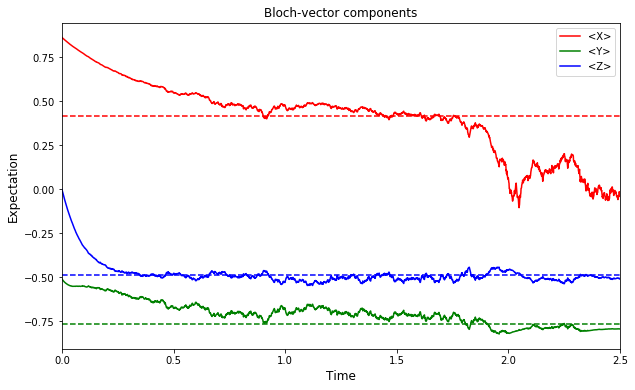

In [58]:
#Plotting the results 
fig, axes = plt.subplots(1,1, figsize=(10,6))

# Plot 1: expectation Bloch vector
n_1 = result.expect[0]
n_2 = result.expect[1]
n_3 = result.expect[2]
axes.plot(tlist, n_1,'r',label="<X>")
axes.plot(tlist, n_2,'g',label="<Y>")
axes.plot(tlist, n_3,'b',label="<Z>")
axes.plot((tlist[0], tlist[tlist.size - 1]), (xBar, xBar), 'r--')
axes.plot((tlist[0], tlist[tlist.size - 1]), (yBar, yBar), 'g--')
axes.plot((tlist[0], tlist[tlist.size - 1]), (zBar, zBar), 'b--')
axes.legend(loc=0)
axes.set_xlim([tlist[0], tlist[tlist.size - 1]])
axes.set_xlabel('Time', fontsize=12)
axes.set_ylabel('Expectation', fontsize=12)
axes.set_title('Bloch-vector components', fontsize=12)

# Second Plot: Bloch vector length (purity)

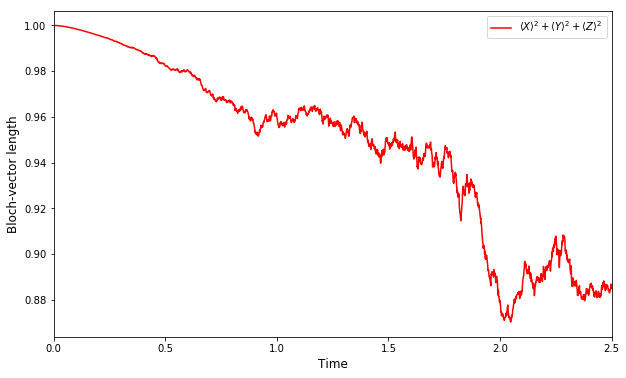

In [59]:
r = n_1**2 + n_2**2 + n_3**2
fig, axes = plt.subplots(1,1, figsize=(10,6))
axes.plot(tlist, r,'r',label=r'$\langle X \rangle^2 + \langle Y \rangle^2 + \langle Z \rangle^2 $')
axes.legend(loc=0)
axes.set_xlim([tlist[0], tlist[tlist.size - 1]])
axes.set_xlabel('Time', fontsize=12)
axes.set_ylabel('Bloch-vector length', fontsize=12)